# How to train supervised machine learning algorithms **without** labeled data?

# Introduction

> *Garbage in, Garbage out!*  
  
There is a reason why this expression is so popular within the data science community.  
The very first step of any data science project, or machine learning design is to **get quality data**. This is performed using different tools, including web scraping, polls, measures from sensors, etc. The data is divided into two parts: **Features** and **Labels**. Features are the inputs of the machine learning algorithm. They will be used to predict the labels after the training process. During the training step (in supervised learning), the algorithm modifies gradually its outputs to resemble the provided labels.  
One of the most costly things in data collection is labeling. It involves usually human manipulation or annotation. Machine learning (and deep learning) algorithms require **large amount** of data to perform optimal training and be able to generalize. This prevent also **overfitting** to happen.  
  
## But what if the data is not labeled?  
When the data is missing a part or all labels, it is virtually impossible to perform supervised training. We must find a way to create targets, using one of the following approaches:
- Manual labeling: performed by in-house data labelers, or using crowdsouring (like Amazon Mechanical Turk)
- Automated labeling: before training the ML algorithm, labels are created using unsupervised training techniques.  

In practice, the amount of required data to train efficiently deep learning algorithms is increasing. Requiring 50k or 100k labeled data points is not unusual in computer vision or natural language processing. We could combine the two approaches, in order to save on costs.  
## Label creation using deep autoencoders
In this article, we will go through the implementation of a labeling process, based on deep autoencoders. This unsupervised (or self-supervised) learning technique aims to learn the data structure by trying to regenerate the data. An autoencoder consists of two parts: encoder and decoder.
<p align="center"> <img src="https://i.imgur.com/1C0bFbG.png"> </p>   


The *encoder* part transforms the input data (the features) into a representation (called also an encoding) via multiple non-linear transformations. The trick is that the network learns at the same time, the inverse transformation in order to reconstruct the data from its representation. The inverse transformation is the *decoder*. When the autoencoder is trained properly, the data structure is **learned**. We could use the encoder then to generate labels, by replacing the decoder by a simple classifier that we train on the available labels.

<p align="center"> <img src="https://i.imgur.com/GvjSbwc.png"> </p>   
  
This technique requires some labels. As we will see later, we only need a fraction of labels that can be obtained manually or via crowdsourcing for a much lower cost. 

In [2]:
#import libraries and setup 
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)
from sklearn.ensemble import RandomForestClassifier as clf


# The MNIST dataset

In this article, we will use the **MNIST** dataset to experiment with the efficiency of autoencoders in label creation. The **MNIST** dataset is a large database of handwritten digits and corresponding numbers. It contains 60000 grayscale images for training and 10000 images for validation/testing. It is considered as the *Hello World* of computer vision machine learning. This dataset can be obtained via multiple sources. We will use **Tensorflow/Keras** datasets to load the data.


In [3]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


The `x_train` tensor contains 60000 matrices of dimension 28x28. Each element of these matrices represents the brightness of a single pixel. The `y_train` tensor contains the labels for each image. We start by normalizing the data and reshaping the matrices to a format that can be used by `matplotlib` for visualization. A one hot encoding will be performed as well, on the labels. This will be used later during the validation/testing.

In [4]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

# one hot encoding labels
y_train_cat = to_categorical(y_train)
y_test_cat= to_categorical(y_test)

Let's show a random sample from the data:

Label = 3 


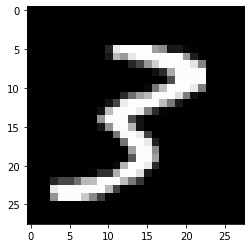

In [5]:
random_label = np.random.randint(0,59999)
plt.imshow(x_train[random_label,:,:], cmap='gray')
print('Label = {} '.format(y_train[random_label]))

The images are in low resolution (28x28). Since they are handwritten, many variations of the same digit can be encountered. The ML algorithm will need a lot of labels to be able to generalize!

# Random forest classifier using the labeled data

In [5]:
# create a classifier on all the data
classifier_all_labels= clf()
classifier_all_labels.fit(x_train.reshape(-1,28*28),y_train_cat)

RandomForestClassifier()

In [6]:
#score of the classifier
classifier_all_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.9034

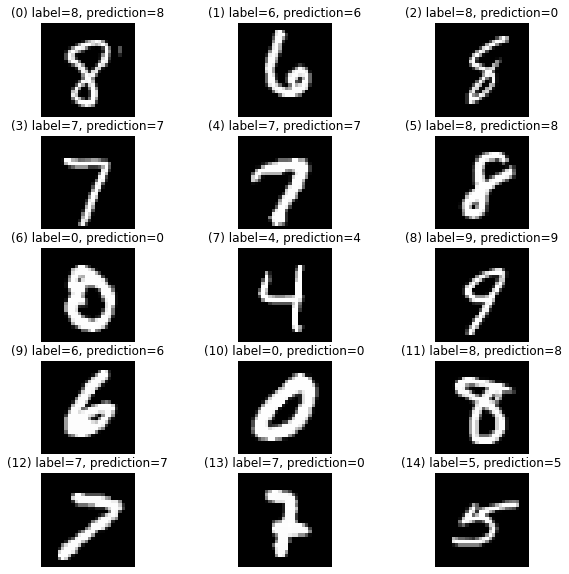

In [7]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_all_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

# train a similar classifier on a small batch of the data

In [8]:
# what if we don't have all the labels
#split the training data into labeled and non labeled
labeled_ratio = 0.01 # 
labeled_index = np.int(len(x_train)*labeled_ratio)
x_train_labeled = x_train[:labeled_index]
x_train_unlabeled = x_train[labeled_index:]
y_train_cat_labeled = y_train_cat[:labeled_index] 
print('Number of labeled data points {} out of {}'.format(labeled_index,x_train.shape[0]))


Number of labeled data points 600 out of 60000


In [9]:
# what if the same model is trained only on a small part of data
classifier_few_labels =  clf()
classifier_few_labels.fit(x_train_labeled.reshape(-1,28*28),y_train_cat_labeled)

RandomForestClassifier()

In [10]:
#score of the classifier
classifier_few_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.4748

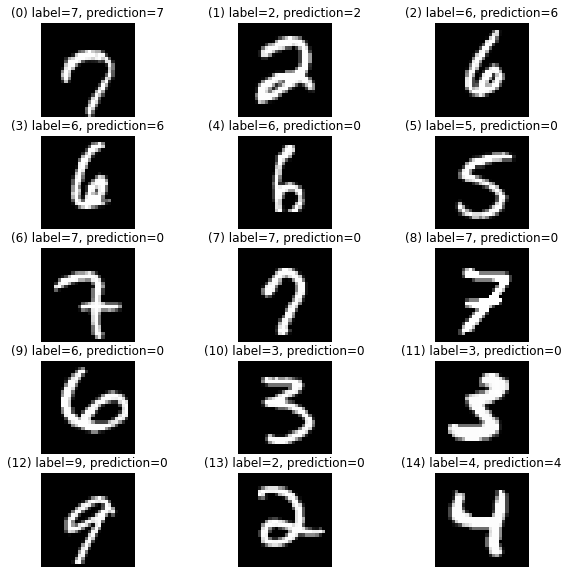

In [11]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    image = img_samples[i]
    pred = classifier_few_labels.predict(image.reshape(-1,28*28))
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, prediction={}'.format(i,label_samples[i],np.argmax(pred)));
    plt.axis('off');

# create an autoencoder using neural nets and convolution

## create an encoder

In [16]:
# create an autoencoder / decoder on the whole data (without labels)
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))

encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
Total params: 92,672
Trainable params: 92,672
Non-trainable params: 0
__________________________________________________

## create a decoder 

In [17]:
encoder_out_dim = encoder.layers[-1].output_shape[1:]
encoder_out_dim

(7, 7, 128)

In [18]:
decoder = Sequential()
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu', input_shape=encoder_out_dim))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)         577       
Total params: 221,953
Trainable params: 221,953
Non-trainable params: 0
_________________________________________________________________


# combine encoder and decoder

In [19]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         221953    
Total params: 314,625
Trainable params: 314,625
Non-trainable params: 0
_________________________________________________________________


In [20]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics=['acc'])

In [21]:
enc_dec.fit(x_train,x_train, batch_size=1000,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es])

Epoch 1/1000
48/48 - 9s - loss: 0.2131 - acc: 0.7966 - val_loss: 0.1729 - val_acc: 0.8090
Epoch 2/1000
48/48 - 9s - loss: 0.1183 - acc: 0.8110 - val_loss: 0.2435 - val_acc: 0.8100
Epoch 3/1000
48/48 - 9s - loss: 0.1071 - acc: 0.8123 - val_loss: 0.4288 - val_acc: 0.8093
Epoch 4/1000
48/48 - 9s - loss: 0.1027 - acc: 0.8128 - val_loss: 0.4631 - val_acc: 0.8093
Epoch 5/1000
48/48 - 9s - loss: 0.0989 - acc: 0.8132 - val_loss: 0.4344 - val_acc: 0.8095
Epoch 6/1000
48/48 - 9s - loss: 0.0956 - acc: 0.8135 - val_loss: 0.5398 - val_acc: 0.8093
Epoch 7/1000
48/48 - 9s - loss: 0.0956 - acc: 0.8135 - val_loss: 0.5202 - val_acc: 0.8093
Epoch 8/1000
48/48 - 9s - loss: 0.0934 - acc: 0.8137 - val_loss: 0.5435 - val_acc: 0.8093
Epoch 9/1000
48/48 - 9s - loss: 0.0926 - acc: 0.8138 - val_loss: 0.5011 - val_acc: 0.8095
Epoch 10/1000
48/48 - 9s - loss: 0.0921 - acc: 0.8139 - val_loss: 0.4717 - val_acc: 0.8097
Epoch 11/1000
Restoring model weights from the end of the best epoch.
48/48 - 9s - loss: 0.0909 - a

In [ ]:
# save models
encoder.save('encoder')
decoder.save('decoder')

In [32]:
# load models
encoder = keras.models.load_model('encoder') 
decoder = keras.models.load_model('decoder') 
enc_dec = Sequential([encoder,decoder])

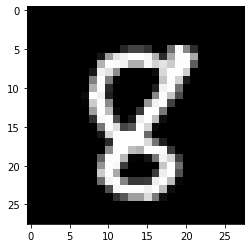

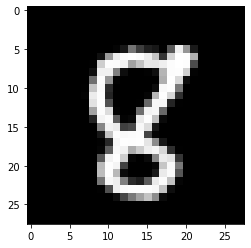

In [34]:
random_label = np.random.randint(0,59999)
img_sample = x_train[random_label,:,:]
plt.imshow(img_sample, cmap='gray');
pred_img = enc_dec.predict(img_sample.reshape((1,28,28,1))) 
plt.figure();
plt.imshow(pred_img.reshape(28,28,1), cmap='gray');


## use the encoder to generate labels

In [35]:
dense_encoder = Sequential()
dense_encoder.add(Flatten(input_shape = encoder_out_dim ))
dense_encoder.add(Dense(10,activation = 'softmax'))
dense_encoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                62730     
Total params: 62,730
Trainable params: 62,730
Non-trainable params: 0
_________________________________________________________________


In [36]:
encoder.trainable = False
labeler = Sequential([encoder, dense_encoder])
labeler.summary()
labeler.compile(optimizer='nadam', loss = 'categorical_crossentropy', metrics=['CategoricalAccuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_18 (Sequential)   (None, 7, 7, 128)         92672     
_________________________________________________________________
sequential_7 (Sequential)    (None, 10)                62730     
Total params: 155,402
Trainable params: 62,730
Non-trainable params: 92,672
_________________________________________________________________


In [37]:
# train the last layer only on the available labels
labeler.fit(x_train_labeled,y_train_cat_labeled, epochs=1000,validation_split=0.2, callbacks=[es])

Epoch 1/1000
15/15 [==============================] - 0s 18ms/step - loss: 1.3565 - categorical_accuracy: 0.6229 - val_loss: 0.9781 - val_categorical_accuracy: 0.7333
Epoch 2/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.4821 - categorical_accuracy: 0.8917 - val_loss: 0.6709 - val_categorical_accuracy: 0.8167
Epoch 3/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.2855 - categorical_accuracy: 0.9354 - val_loss: 0.5491 - val_categorical_accuracy: 0.8667
Epoch 4/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1898 - categorical_accuracy: 0.9646 - val_loss: 0.5202 - val_categorical_accuracy: 0.8417
Epoch 5/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.1364 - categorical_accuracy: 0.9833 - val_loss: 0.4975 - val_categorical_accuracy: 0.8667
Epoch 6/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1001 - categorical_accuracy: 0.9917 - val_loss: 0.4634 - val_categorical_accuracy: 0.8667
Epo

In [38]:
labeler.evaluate(x_test,y_test_cat)

313/313 [==============================] - 1s 4ms/step - loss: 0.3779 - categorical_accuracy: 0.8821


[0.3779071569442749, 0.882099986076355]

In [39]:
labeler.evaluate(x_train,y_train_cat)

1875/1875 [==============================] - 7s 4ms/step - loss: 0.4053 - categorical_accuracy: 0.8758


[0.4053490459918976, 0.8758166432380676]

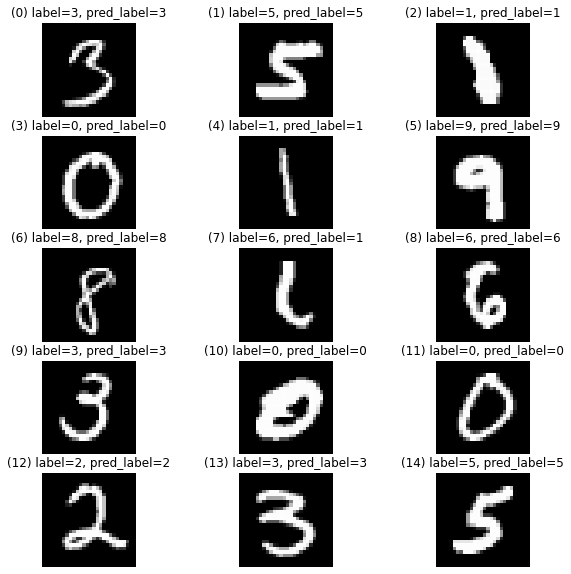

In [40]:
# a test on random images
random_labels = np.random.randint(0,9999,15)
img_samples = x_test[random_labels,:,:,:]
label_samples = y_test[random_labels]
predicted_labels = labeler.predict(img_samples)
plt.figure(figsize=(10, 10));
for i in range(15):
    plt.subplot(5,3,i+1)
    pred_label = np.argmax(predicted_labels[i])+1
    image = img_samples[i]
    plt.imshow(image, cmap='gray');
    plt.title('({}) label={}, pred_label={}'.format(i,label_samples[i],np.argmax(predicted_labels[i])));
    plt.axis('off');


# train a classifier using the avalaible labels and the generated labels

In [41]:
new_labels = np.round(labeler.predict(x_train_unlabeled))

In [42]:
# improve the weak classifier using the new labeled data
classifier_generated_labels = clf()
classifier_generated_labels.fit(x_train.reshape(-1,28*28),np.concatenate((y_train_cat_labeled,new_labels)))


RandomForestClassifier()

In [43]:
# score on the test labels
classifier_generated_labels.score(x_test.reshape(-1,28*28),y_test_cat)

0.8123

# conclusions and future work